In [31]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

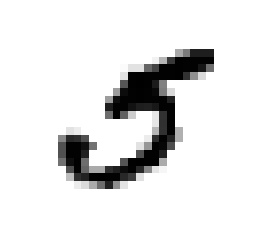

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

X, y = mnist['data'], mnist['target']

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [3]:
import numpy as np

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [4]:
# Train model to identify 5 & not-5
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [5]:
# High accuracy scores due more to lack of 5s than actual quality of model
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.95915,  0.9475 ,  0.9666 ])

In [6]:
# Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53102,  1477],
       [ 1058,  4363]])

In [7]:
from sklearn.metrics import precision_score, recall_score

# When model guesses 5, % time it's correct
print(precision_score(y_train_5, y_train_pred))
# Model detects % of all 5s
recall_score(y_train_5, y_train_pred)

0.747089041096


0.80483305663161775

In [8]:
# F1 score = harmonic mean of precision & recall
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.77488677737323508

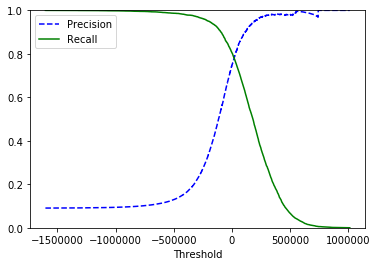

In [9]:
# Calculate precision/recall curves at various thresholds
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [10]:
y_train_pred_90 = (y_scores > 250000)
print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90)

0.968565815324


0.36377052204390337

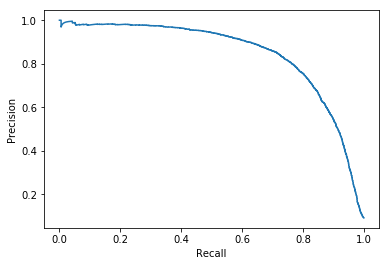

In [11]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

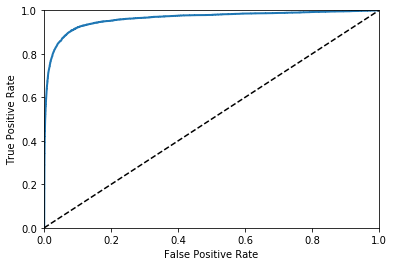

In [12]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96242085267471333

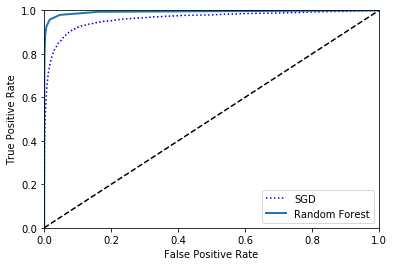

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [15]:
roc_auc_score(y_train_5, y_scores_forest)

0.99311809912179183

In [16]:
# One vs One classifier instead of One vs All
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

ovo_clf.predict([some_digit])

array([ 5.])

In [17]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [18]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.2,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [19]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.88257349,  0.85249262,  0.86062909])

In [20]:
# Scaling features for better accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.91026795,  0.90849542,  0.91168675])

In [21]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5736,    2,   20,    8,   11,   45,   49,    7,   40,    5],
       [   1, 6476,   43,   22,    6,   43,    7,    9,  124,   11],
       [  57,   39, 5325,  100,   86,   23,   95,   55,  164,   14],
       [  55,   46,  136, 5347,    4,  226,   33,   54,  137,   93],
       [  25,   29,   34,    4, 5392,   10,   53,   24,   81,  190],
       [  78,   44,   36,  180,   78, 4619,  108,   24,  160,   94],
       [  36,   25,   43,    2,   44,   90, 5621,    8,   49,    0],
       [  26,   26,   65,   28,   57,   10,    8, 5782,   15,  248],
       [  60,  152,   77,  143,   19,  154,   57,   25, 5029,  135],
       [  48,   37,   24,   90,  167,   35,    2,  183,   81, 5282]])

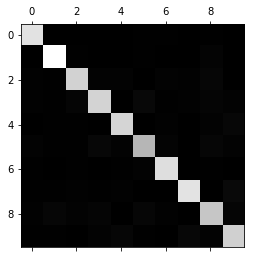

In [22]:
# Plot of confusion matrix by volume (lighter = more)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

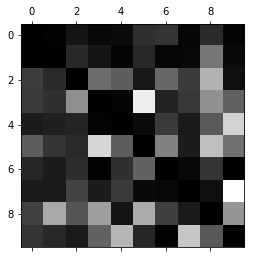

In [23]:
# Normalize quantities, zero-out correct predictions, and re-plot
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

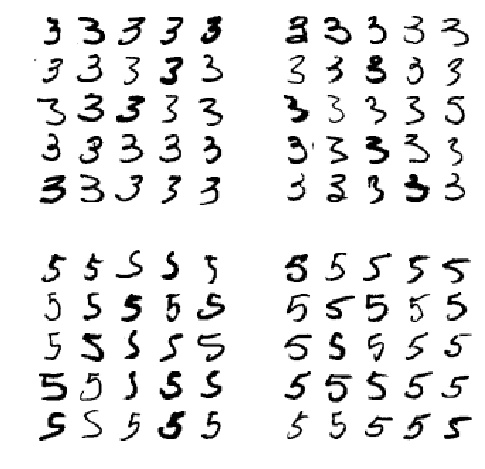

In [36]:
# Take closer look at errors w/ 3s & 5s
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [25]:
# Multilabel Classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [26]:
# Get average F1 score for all labels
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# f1_score(y_train, y_train_knn_pred, average='macro')

In [29]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_test_mod = X_train + noise
y_train_mod = X_train
y_test_mod = X_test

In [39]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5]])
# plot_digit(clean_digit)